# Bayesian regression for storm erosion prediction
Joshua Simmons 05/2022

Further ideas:
 - https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings

In [56]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed, widgets

# MAP regression
import sklearn.linear_model as lm

#numpyro
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

# plotting
from functions import (plot_regression, plot_pareto_points, draw_fit) 
# data
from functions import(load_shoreline_data, load_wave_data, clean_dshoreline_data) 
# analysis
from functions import (find_pareto_front,generate_storm_dataset)
# models
from functions import (linear_model)



## Load the data
Choose the transect name from [the coastsat website](http://coastsat.wrl.unsw.edu.au).
We will need:
- Wave data - to calculate storm energy. If this is not previously downloaded, we will fetch from ERA5
- Shoreline data - to calculate shoreline change between storms
- Storm dataset - using the wave and shoreline data, create a dataset for each storm event which has an associated energy (E) and shoreline change (dshl)


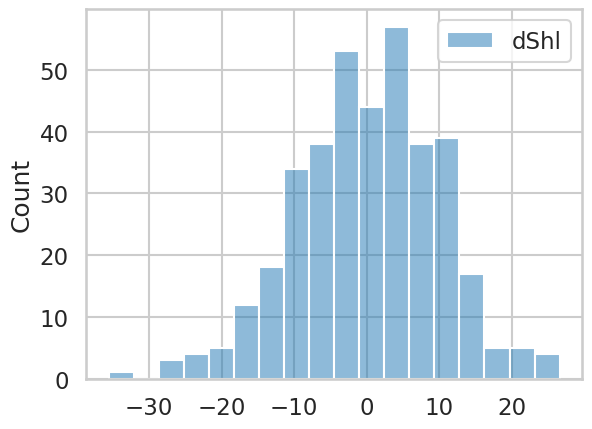

In [3]:
transect_name = 'aus0206-0005'
raw_shl_data = load_shoreline_data(transect_name=transect_name)
raw_wave_data = load_wave_data(transect_name=transect_name)
shl_data = generate_storm_dataset(raw_shl_data, raw_wave_data)

# Check the dsitribution with a quick hist plot
diff_shl_data = raw_shl_data.diff()
diff_shl_data.columns = ['dShl'] 
sns.histplot(diff_shl_data.dropna())
None

## Clean the storm dataset
The reality of this data is that it is quite noisy and really we are taking a very simplistic approach to modelling it. So to make life easier for ourselves, we will clean the data to try and find the equivalent of the barless conditions in the Harley 2009 paper.

![Source: Harley 2009](img/Harley2009_fit.png)
Source: Harley 2009

As such we will look for the Pareto front which defines the 

We will need to choose:
- paretoThresh: the threshold for distance from the Pareto front to be considered a valid storm event
- timeThresh: the maximum time between pre- and post- storm surveys to avoid problems due to low availability of satellite data
- energyThresh: the minimum energy to be considered a valid event

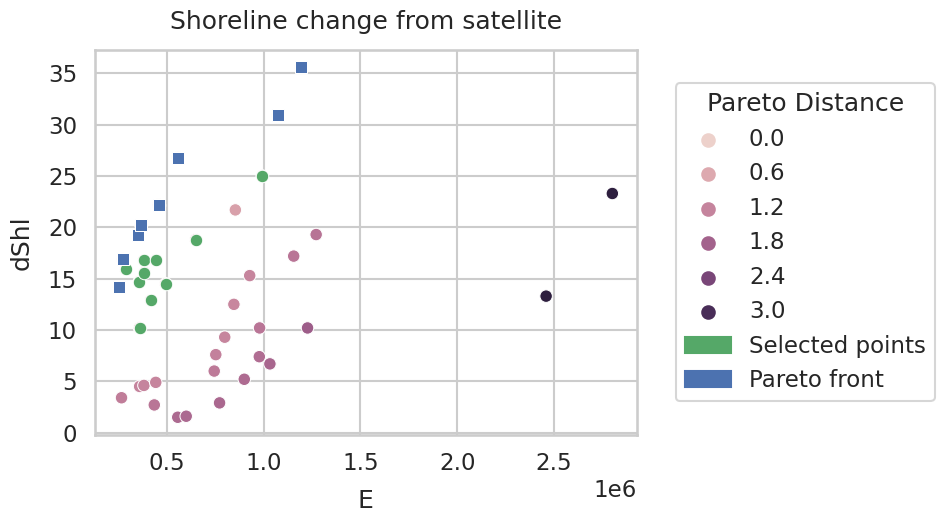

In [28]:
pareto_thresh = 0.75
time_thresh = 100
energy_thresh = 0.25e6

x, y, plotData = clean_dshoreline_data(shl_data, pareto_thresh, time_thresh, energy_thresh)

log_scale=False
plot_pareto_points(plotData,pareto_thresh=pareto_thresh)
None

## Fit an ordinary Linear Regression
First we will transform the points to be in log space so that instead of the equation from Harley (2009):
$$\Delta W=aE^b$$
where $a$ and $b$ are the parameters we want to fit, we have:
$$\log(\Delta W)=\log(a)+b*\log(E)$$
where $\log(a)$ and $b$ are the parameters we want to fit (thanks to our handy friends the log laws).

We will then use `scipy.linear_model.LinearRegression` to fit a linear regression.

In [30]:
x_log = np.log(x)
y_log = np.log(y)

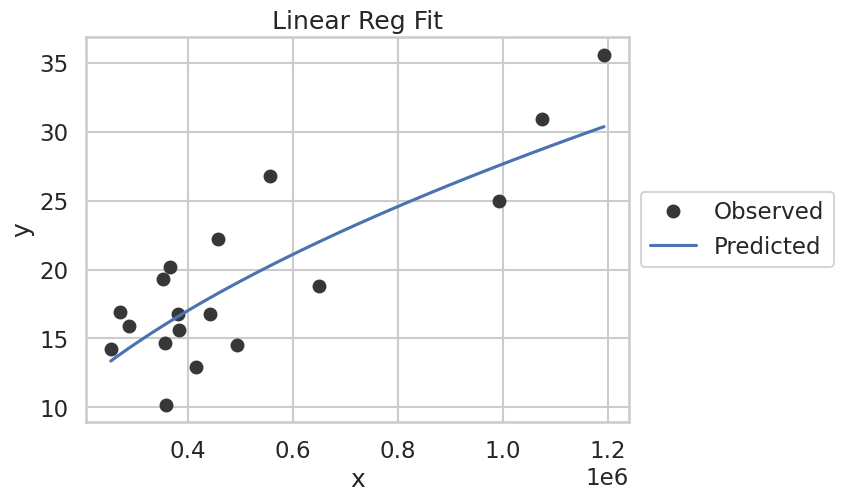

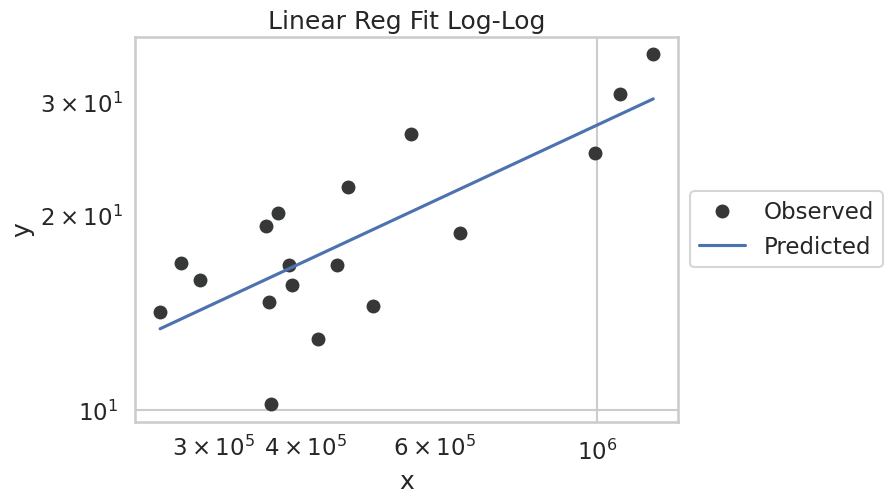

In [78]:
# fit a linear model to the data
freq_model = lm.LinearRegression()
freq_model.fit(x_log.reshape(-1,1),y_log)
# get a sample_x for plotting a line and predict y
sample_x = np.linspace(x.min(),x.max(),101)
y_pred = freq_model.predict(np.log(sample_x).reshape(-1,1))

# Now draw the ft on both orginal scale and log-log
draw_fit(x,y,sample_x,y_pred=np.exp(y_pred),title='Linear Reg Fit')
draw_fit(x,y,sample_x,y_pred=np.exp(y_pred),log_scale=True,title='Linear Reg Fit Log-Log')
None

## Fit a Bayesian Linear Regression using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. Our model looks similar to before:
$$\log(\Delta W)=\log(a)+b*\log(E) + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,\sigma)$$
but here we have explicitly stated that the model fits the data with some random residual or error ($\epsilon$). We can then model this error when fitting to the data, to take into account uncertainty.

We have to make some assumptions about the distribution of our residuals. In our case we will say they follow a normal distribution with a mean of zero (i.e., our linear model fit has no bias) and a standard deviation $\sigma$. $\sigma$ then becomes a third parameter that we will need to sample to determine the variance of our residuals after fitting the model. This is an okay assumption for our very simple case, give our data are in log space and that we don't want to think *too* hard about it for now. 

Now we have to adopt some priors (see above for links to resources on Bayesian approaches) for our three model parameters (we will ditch the log on $a$ for ease of notation). These are: $a$ (Gaussian prior - $\mathcal{N}$), $b$ (Gaussian prior - $\mathcal{G}$) and $\sigma$ (Exponential prior, as we need sigma to be positive - $Exp$).

$$a \sim \mathcal{N}(0,10)$$
$$b \sim \mathcal{N}(1,0.5)$$
$$\sigma \sim Exp(1)$$

We will visualise these further along to check them, but the main thing is trying to ensure that the range of predictions that our modles makes with these priors is reasonable. As an example, we wouldn't expect $b$ to be negative (so a normal distribution centered at zero would be a poor choice) as this would imply that as the energy of a storm increases, the shoreline change it would cause decreases! Otherwise, for this particular case we are going to keep our priors weakly informative, so that we don't have to think too hard.

NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model ($log(a)$ and $b$). You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).<br>
For an introduction to Bayesian methods, I thoroughly recommend Richard McElreath's [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) book (via kindle app [here](https://www.amazon.com.au/Statistical-Rethinking-Book-Bayesian-Examples-ebook/dp/B09RW8BYQR/ref=tmm_kin_swatch_0?_encoding=UTF8&qid=&sr=)) with associated code examples. 

In [188]:
def linear_model(energy,dshl=None):
    '''
    Define linear model with priors for the parameters and model error
    '''
    # Define priors
    a = numpyro.sample("a",dist.Normal(0, 10))
    b = numpyro.sample("b",dist.Normal(1, 0.5))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * energy
    # store the model prediction before we account for the error
    numpyro.deterministic("mu", mu)
    # and then finally sample so we can compare to our observations
    dshl_modelled = numpyro.sample("dshl_modelled", dist.Normal(mu, sigma), obs=dshl)

Now lets sample from out prior distributions, check what these look like with arviz. You could also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [189]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=100)(
    rng_key_, energy=x_log
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)
arviz_priors

Inference data with groups:
	> prior

################################################################################
Priors


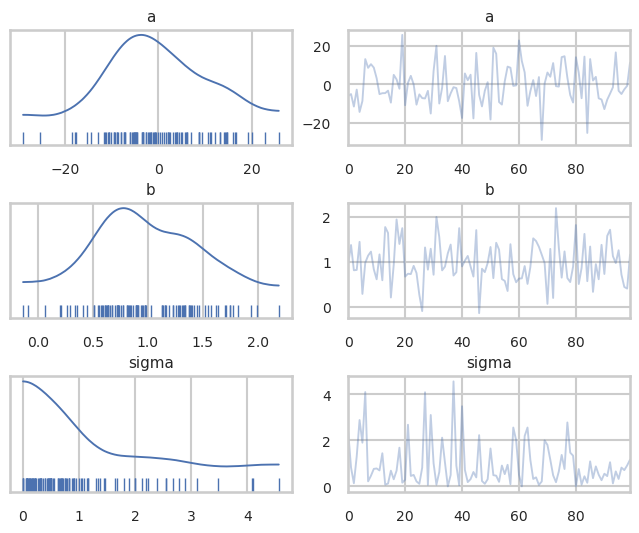

In [200]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['a','b','sigma'],
    figsize=(8,6),
    rug=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

In [192]:
# settings 
num_samples = 5000
num_warmup = int(0.25 * num_samples)
ci = 0.68

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)

# now run the sampler for num_samples+burnin
mcmc_obj.run(
    rng_key_, energy=x_log, dshl=y_log
)
mcmc_obj.print_summary()
# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

sample: 100%|██████████| 6250/6250 [00:09<00:00, 684.82it/s, 55 steps of size 2.61e-02. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -4.29      1.56     -4.26     -6.58     -1.46   1083.49      1.00
         b      0.55      0.12      0.55      0.34      0.73   1084.69      1.00
     sigma      0.23      0.04      0.22      0.16      0.29   1292.10      1.00

Number of divergences: 0


We will also get predcitive samples (simulations model + error) which will make more sense in the plots below. We add these to an arviz object for easy plotting.

In [193]:
# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=x_log)

arviz_posterior = az.from_numpyro(
    mcmc_obj,
    prior=prior_samples,
    posterior_predictive=posterior_predictive,
)
arviz_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Plot the posterior distributions for our three parameters and check that they look reasonable. We also want to check the traces (right hand plots) to ensure everything has gone well during the MCMC sampling. Again we won't worry too much about that for this fairly simple case. Notice as well how far our posteriors have deviated from our priors based on the data we have observed.

################################################################################
Posterior


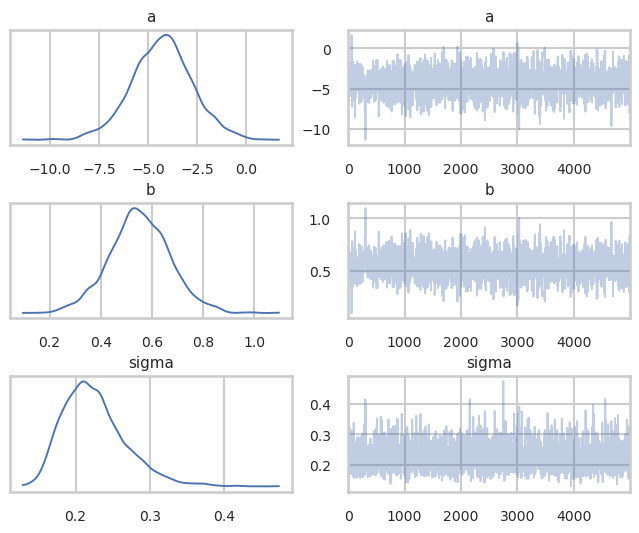

In [202]:
print('#'*80)
print('Posterior')
az.plot_trace(
    arviz_posterior,
    var_names=['a','b','sigma'],
    figsize=(8,6),
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot the results

We can now plot our model predictions with uncertainty for our selected confidence interval (`ci`) - say 68%. Notice that we plot two uncertainty bands, the first is the confidence interval for our linear model (blue bands) - what are the forms our linear fit could take. This eflects the posteriors for  parameters $a$ and $b$, as we are uncertain of their exact value. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (confidence interval given by the orange bands) incorporates model and the error which describe our data (which we have assumed to $\mathcal{N}(0,\sigma)$). These bands should include approximately 68% of our data points, matching the `ci` we have chosen.

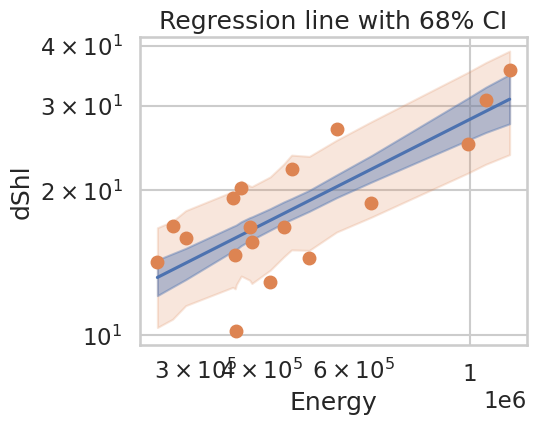

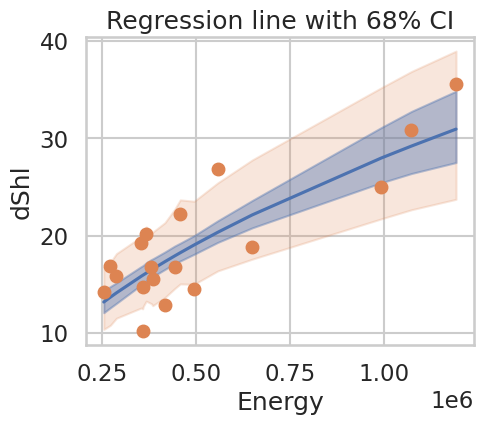

In [199]:
mean_mu = jnp.mean(posterior_predictive['mu'], axis=0)
# hpdi is used to compute the confidence intervals
hpdi_mu = hpdi(posterior_predictive['mu'], ci)
hpdi_sim_y = hpdi(posterior_predictive['dshl_modelled'], ci)

# now plot the results
ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y), log_scale=True)
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with {}% CI".format(int(ci * 100))
)
ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y))
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with {}% CI".format(int(ci * 100))
)
None